In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline

## Загрузка данных
Считаем и посмотрим на данные:

In [2]:
data = pd.read_csv("Gasnikov/trips.csv", names=["i", "j", "T_ij", "r_ij", "dist_ij"])

N = max(data["i"].max(), data["j"].max())

T_real = np.zeros((N, N))
time_real = np.zeros((N, N))
dist_real = np.zeros((N, N))
for _, row in data.iterrows():
    i, j = int(row["i"]), int(row["j"])
    if (i - 1 == j - 1 == 19):
        print(row)
    T_real[i - 1, j - 1] = row["T_ij"]
    time_real[i - 1, j - 1] = row["r_ij"]
    dist_real[i - 1, j - 1] = row["dist_ij"]

i          20.0
j          20.0
T_ij        5.0
r_ij       12.0
dist_ij     0.0
Name: 204, dtype: float64


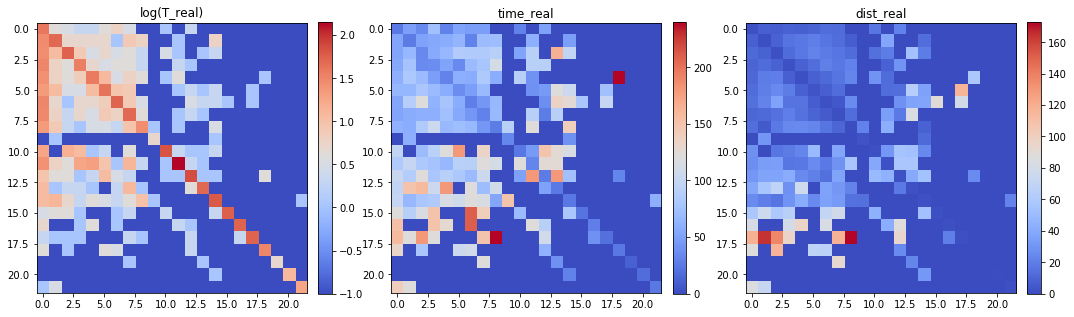

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

i = axs[0].imshow(np.log10(T_real + 1e-1), cmap="coolwarm")
axs[0].set_title("log(T_real)")
fig.colorbar(i, ax=axs[0], fraction=0.046, pad=0.04)

i = axs[1].imshow(time_real, cmap="coolwarm")
axs[1].set_title("time_real")
fig.colorbar(i, ax=axs[1], fraction=0.046, pad=0.04)

i = axs[2].imshow(dist_real, cmap="coolwarm")
axs[2].set_title("dist_real")
fig.colorbar(i, ax=axs[2], fraction=0.046, pad=0.04)

plt.savefig("data.png")
plt.show()

Видим, что диагонали ненулевые (кроме 1 элемента в $dist\_real$, что мы поправим меньше) - это логично, т.к. даже в пределах одного района расстояние необходимое людям для передвижения от места жительства на работу ненулевое. В том месте где есть ноль мы заменим на среднее по диагонали. Остальные неизвестные значения мы заполним $+\inf$ так как тогда в нашей модели в них будут предсказываться почти 0, что нам и нужно для $MSE$

Положим неизвестные значения по времени/расстоянию равными $+\inf$, т.к. для них надо получать $T_{ij}=0$.

In [4]:
inf = 1e10
time_diag = time_real[np.arange(0, N), np.arange(0, N)]
time_diag[time_diag == 0] = time_diag.mean()
time_real[time_real == 0] = inf
time_real[np.arange(0, N), np.arange(0, N)] = time_diag

dist_diag = dist_real[np.arange(0, N), np.arange(0, N)]
dist_diag[dist_diag == 0] = dist_real.mean()
dist_real[dist_real == 0] = inf
dist_real[np.arange(0, N), np.arange(0, N)] = dist_diag

Наконец зададим ограничения (истоки/стоки) как суммы по строкам/столбцам искомой матрицы корреспонденции.

In [5]:
L_real = T_real.sum(axis=1, keepdims=True) # Исход. корреспонденция
W_real = T_real.sum(axis=0, keepdims=True) # Вход. корреспонденция

## Описание функций

В начале распишем используемые функционалы потерь

In [6]:
class LossFunction(object):
    def __call__(*args, **kwars):
        raise NotImplementedError("Call must be implemented")


class MSE(LossFunction):
    def __call__(self, actual, predicted):
        """
        Returns mean squared error between actual and predicted data

        Parameters:
        ----------
        actual: np.array
            Array of actual data
        predicted: np.array
            Predicted data, must be of the same size as left
        Returns:
        ----------
        float: MSE(actual, predicted)
        """
        return ((actual - predicted) ** 2).mean()


class MAPE(LossFunction):
    def __call__(self, actual, predicted, mask=None):
        """
        Returns mean absolute percentage error between actual and predicted data. 
        If provided, mask array is used to calculate MAPE only over masked data

        Parameters:
        ----------
        actual: np.array
            Array of actual data
        predicted: np.array
            Predicted data, must be of the same size as left
        mask: np.array
            Optional argument, used to mask data if provided (only masked data 
            will be used to calculate MAPE, can be used to avoid missing data) 
        Returns:
        ----------
        float: MAPE
        """
        eps = 1e-10
        if mask is None:
            act_m = actual
            pred_m = predicted
        else:
            act_m = actual[mask]
            pred_m = predicted[mask]
        return (np.abs(act_m - pred_m) / (np.abs(actual) + eps)).mean()


class MaxError(LossFunction):
    def __call__(self, actual, predicted):
        """
        Returns maximum absolute deviation between actual and predicted data

        Parameters:
        ----------
        actual: np.array
            Array of actual data
        predicted: np.array
            Predicted data, must be of the same size as left
        Returns:
        ----------
        float: maximum absolute deviation, np.abs(actual-forecast).max()
        """
        return np.abs(actual - predicted).max()

$TLF$, или функция тяготения - это то как входят матрицы потерь в нашу функцию пересчета $T_{pred}$. Основная рассматриваемая модель - в которой функция тяготения имеет вид $e^{-\alpha\cdot dist^{\beta}\cdot time^{\gamma}}$. В данной модели три параметра — степени $\beta,\gamma$, которые мы будем перебираем по сетке, и $\alpha$ который подбирается наилучшим образом (делением отрезка).

In [7]:
class TravelLossFunction(object):
    def __call__(*args, **kwars):
        raise NotImplementedError("Call must be implemented")


class ExponentialTLF(TravelLossFunction):
    def __init__(self, alpha=0.01, **kwargs):
        self.alpha = alpha

    def __call__(self, distances):
        """
        Returns exponential tlf with fixed alpha applied to distances

        Parameters:
        ----------
        distances: np.array
            Array of distances
        Returns:
        ----------
        np.array: exp(-alpha * distances), elementwise
        """
        return np.exp(-self.alpha * distances)


class ExponentialTLFDistTime(TravelLossFunction):
    def __init__(self, alpha=0.01, beta=0.5, gamma=0.5, **kwargs):
        self.etlf = ExponentialTLF(alpha)
        self.beta = beta
        self.gamma = gamma

    def __call__(self, distances, times):
        """
        Returns exponential tlf with fixed alpha applied to cost array obtained as
        cost = (distances ** beta) * (times ** gamma)

        Parameters:
        ----------
        distances: np.array
            Array of distances
        times: np.array
            Array of times
        Returns:
        ----------
        np.array: exp(-alpha * (distances ** beta) * (times ** gamma)), elementwise
        """
        cost = (distances ** self.beta) * (times ** self.gamma)
        return self.etlf(cost)


class PolynomialTLF(TravelLossFunction):
    def __init__(self, alpha=0.01, beta=0.5, gamma=0.5, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def __call__(self, distances, times):
        """
        Returns polynomial tlf with fixed alpha applied to cost array obtained as
        cost = (distances ** beta) * (times ** gamma)

        Parameters:
        distances: np.array
            Array of distances
        times: np.array
            Array of times
        Returns:
        ----------
        np.array: 1 / (alpha * (distances ** beta) * (times ** gamma)), elementwise
        """
        cost = (distances ** self.beta) * (times ** self.gamma)
        return 1 / (self.alpha * cost)

Теперь опишем функции для пересчета $T_{pred}$, а также для обновления двойственных переменных $A$ и $B$

In [8]:
def make_T_pred(pred_A, pred_B, L_real, W_real, travel_loss):
    """
    parameters:
        pred_A: np.array, (N, 1)
        pred_B: np.array, (1, N)
        L_real: np.array, (N, 1)
        W_real: np.array, (1, N)
        travel_loss: np.array(N, N)
    """
    return ((pred_A * L_real) @ (pred_B * W_real)) * travel_loss

def update_A(pred_B, W_real, travel_loss):
    """
    parameters:
        pred_B: np.array, (1, N)
        W_real: np.array, (1, N)
        travel_loss: np.array(N, N)
    """
    eps = 1e-10
    return 1 / (travel_loss @ ((W_real * pred_B).T) + eps)

def update_B(pred_A, L_real, travel_loss):
    """
    parameters:
        pred_A: np.array, (N, 1)
        L_real: np.array, (N, 1)
        travel_loss: np.array(N, N)
    """
    eps = 1e-10
    return 1 / (((L_real * pred_A).T) @ travel_loss + eps)


def update_AB(pred_A, pred_B, L_real, W_real, travel_loss):
    pred_A_new = update_A(pred_B, W_real, travel_loss)
    pred_B_new = update_B(pred_A_new, L_real, travel_loss)
    return pred_A_new, pred_B_new

Наконец опишем функцию для поиска $\alpha$ - на каждом шаге она берет отрезок, делит его на $k+2$ частей, вычисляет $loss$ во всех точках кроме крайних и переходит к подотрезку с центром в точке в которой был достигнут минимум $loss$.

In [9]:
def find_alpha(left, right, conf, k=3, max_depth=10, store_losses=False):
    eps = 1e-4

    dist_real = conf["travel_loss_kwargs"]["dist_real"]
    time_real = conf["travel_loss_kwargs"]["time_real"]

    update_AB = conf["update_AB"]
    make_T_pred = conf["make_T_pred"]
    loss = conf["loss"]
    L_real = conf["L_real"]
    W_real = conf["W_real"]
    T_real = conf["T_real"]
    MSE_loss = MSE()
    
    alphas = None
    full_losses = []

    for depth in range(max_depth):
        alphas = np.linspace(left, right, k + 2)
        best_losses = []
        for alpha in alphas[1:k+1]:
            travel_loss_function = conf["travel_loss_function"](alpha, **conf["travel_loss_kwargs"])
            losses = []
            
            pred_A = np.ones((N, 1))
            pred_B = np.ones((1, N))
            while True:
                travel_loss = travel_loss_function(dist_real, time_real)

                pred_A_new, pred_B_new = update_AB(pred_A, pred_B, L_real, W_real, travel_loss)

                T_pred = make_T_pred(pred_A, pred_B, L_real, W_real, travel_loss)

                if store_losses and depth == max_depth - 1:
                    losses.append(loss(T_real, T_pred))

                if (MSE_loss(pred_A_new, pred_A) / MSE_loss(pred_A_new, 0) < eps and 
                    MSE_loss(pred_B_new, pred_B) / MSE_loss(pred_B_new, 0) < eps
                   ):
                    best_losses.append(loss(T_real, T_pred))
                    break
                pred_A, pred_B = pred_A_new, pred_B_new
            if store_losses and depth == max_depth - 1:
                full_losses.append(losses)
        best_i = np.argmin(best_losses) + 1
        left = alphas[best_i - 1]
        right = alphas[best_i + 1]
    if store_losses:
        return alphas[best_i], np.array(best_losses).min(), full_losses[np.argmin(best_losses)]
    else:
        return alphas[best_i], np.array(best_losses).min()

## Эксперимент

In [10]:
conf = {
    "travel_loss_function": ExponentialTLFDistTime,
    "travel_loss_kwargs": {
        "beta": 1,
        "gamma": 0.0,
        "dist_real": dist_real,
        "time_real": time_real
    },
    "update_AB": update_AB,
    "make_T_pred": make_T_pred,
    "loss": MSE(),
    "L_real": L_real,
    "W_real": W_real,
    "T_real": T_real
}

Мы перебираем степени матриц расстояний/времени от 0 до 1 т.к. 1 кажется логичным верхним пределом - люди тратят время на поездку и теряют ровно столько, сколько могли бы заработать за это время. При этом чем дальше человек едет тем больше у него возможностей, так что и потери его будут расти возможно даже медленнее чем линейно.

In [11]:
grid_size = 11

betas = np.linspace(0.0, 1.0, grid_size)
gammas = np.linspace(0.0, 1.0, grid_size)

beta_gamma_loss = np.zeros((grid_size, grid_size))
beta_gamma_alphas = np.zeros((grid_size, grid_size))

for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        conf["travel_loss_kwargs"]["beta"] = beta
        conf["travel_loss_kwargs"]["gamma"] = gamma
        alpha, loss = find_alpha(0.0, 10.0, conf, k=3, max_depth=10)
        beta_gamma_loss[i, j] = loss
        beta_gamma_alphas[i, j] = alpha
    

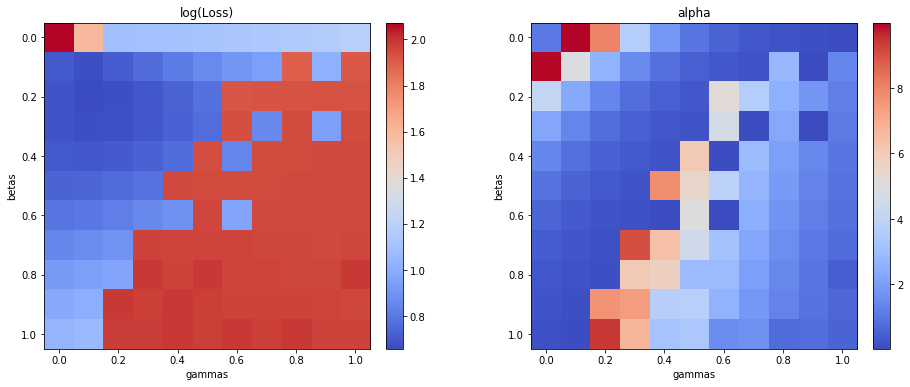

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

i = axs[0].imshow(np.log10(beta_gamma_loss), cmap="coolwarm")
axs[0].set_title("log(Loss)")
axs[0].set_xlabel("gammas")
axs[0].set_xticks([0, 2, 4, 6, 8, 10]) 
axs[0].set_xticklabels(np.linspace(0.0, 1.0, (grid_size + 1) // 2).round(1))
axs[0].set_ylabel("betas")
axs[0].set_yticks([0, 2, 4, 6, 8, 10]) 
axs[0].set_yticklabels(np.linspace(0.0, 1.0, (grid_size + 1) // 2).round(1))

fig.colorbar(i, ax=axs[0], fraction=0.046, pad=0.04)

i = axs[1].imshow(beta_gamma_alphas, cmap="coolwarm")
axs[1].set_title("alpha")
axs[1].set_xlabel("gammas")
axs[1].set_xticks([0, 2, 4, 6, 8, 10]) 
axs[1].set_xticklabels(np.linspace(0.0, 1.0, (grid_size + 1) // 2).round(1))
axs[1].set_ylabel("betas")
axs[1].set_yticks([0, 2, 4, 6, 8, 10]) 
axs[1].set_yticklabels(np.linspace(0.0, 1.0, (grid_size + 1) // 2).round(1))
fig.colorbar(i, ax=axs[1], fraction=0.046, pad=0.04)

plt.savefig("3_param_results.png")
plt.show()

Видим, что лучшие результаты получаются когда суммарная степень $\beta+\gamma$ заметно меньше единицы. 

In [13]:
ind = np.unravel_index(beta_gamma_loss.argmin(), beta_gamma_loss.shape)
beta = betas[ind[0]]
gamma = gammas[ind[1]]
conf["travel_loss_kwargs"]["beta"] = beta
conf["travel_loss_kwargs"]["gamma"] = gamma
alpha, loss = find_alpha(0.0, 10.0, conf, k=3, max_depth=20)
print("Best beta: {:.03f}, Best gamma:  {:.03f}".format(beta, gamma))
print("Best alpha: {:.03f}".format(alpha))
print("Best loss: {:.03f}".format(loss))

Best beta: 0.200, Best gamma:  0.100
Best alpha: 2.364
Best loss: 4.551


In [14]:
conf["travel_loss_kwargs"]["beta"] = 1
conf["travel_loss_kwargs"]["gamma"] = 0
alpha, loss = find_alpha(0.0, 10.0, conf, k=3, max_depth=20)
print("beta: {:.03f}, gamma: {:.03f}".format(1, 0))
print("Best alpha: {:.03f}".format(alpha))
print("Best loss: {:.03f}".format(loss))

beta: 1.000, gamma: 0.000
Best alpha: 0.167
Best loss: 11.038


### Графики

Взглянем на несколько графиков сходимости (не по критерию останова, а именно по интересующему нас $MSE$ между реальной и восстановленной матрицами корреспонденции).

In [15]:
grid_size = 10

betas = np.linspace(0.1, 1.0, grid_size)
gammas = np.linspace(0.1, 1.0, grid_size)

beta_gamma_loss = np.zeros((grid_size, grid_size))
beta_gamma_alphas = np.zeros((grid_size, grid_size))
beta_gamma_losses = []

for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        conf["travel_loss_kwargs"]["beta"] = beta
        conf["travel_loss_kwargs"]["gamma"] = gamma
        alpha, loss, full_losses = find_alpha(0.0, 10.0, conf, k=3, max_depth=10, store_losses=True)
        beta_gamma_loss[i, j] = loss
        beta_gamma_alphas[i, j] = alpha
        beta_gamma_losses.append(full_losses)

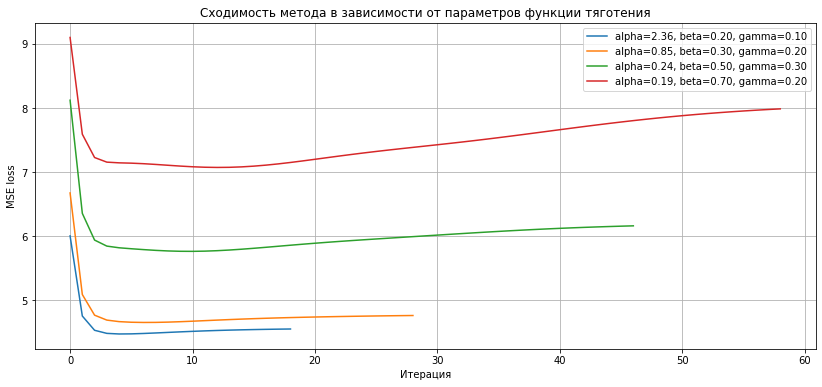

In [16]:
flat_ind = beta_gamma_loss.flatten().argsort()[np.array([0, 4, 19, 29])]
ind = np.unravel_index(flat_ind, beta_gamma_loss.shape)
plt.figure(figsize=(14, 6))
plt.grid(True)

for i in range(ind[0].shape[0]):
    beta = betas[ind[0][i]]
    gamma = gammas[ind[1][i]]
    alpha = beta_gamma_alphas[ind[0][i], ind[1][i]]
    losses = beta_gamma_losses[flat_ind[i]]
    plt.plot(losses[1:], label="alpha={:0.2f}, beta={:0.2f}, gamma={:0.2f}".format(alpha, beta, gamma))
    
plt.title("Сходимость метода в зависимости от параметров функции тяготения")
plt.ylabel("MSE loss")
plt.xlabel("Итерация")
plt.legend()

plt.savefig("converg.png")
plt.show()

Здесь синим показан график соответствующий наилучшему набору $\alpha,\beta,\gamma$. Провал в начале соответствует решениям не соответствующим ограничениям (суммам по строкам/столбцам матрицы корреспонденции, по-другому стокам/истокам нашей модели).

### Полином

Дополнительно можно посмотреть на полиномиальную модель функции тяготения, описанную выше. 

In [17]:
grid_size = 21

betas = np.linspace(0.0, 2.0, grid_size)
gammas = np.linspace(0.0, 2.0, grid_size)

beta_gamma_loss = np.zeros((grid_size, grid_size))
beta_gamma_alphas = np.zeros((grid_size, grid_size))

conf["travel_loss_function"] = PolynomialTLF

for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        conf["travel_loss_kwargs"]["beta"] = beta
        conf["travel_loss_kwargs"]["gamma"] = gamma
        alpha, loss = find_alpha(0.0, 1000.0, conf, k=3, max_depth=10)
        beta_gamma_loss[i, j] = loss
        beta_gamma_alphas[i, j] = alpha

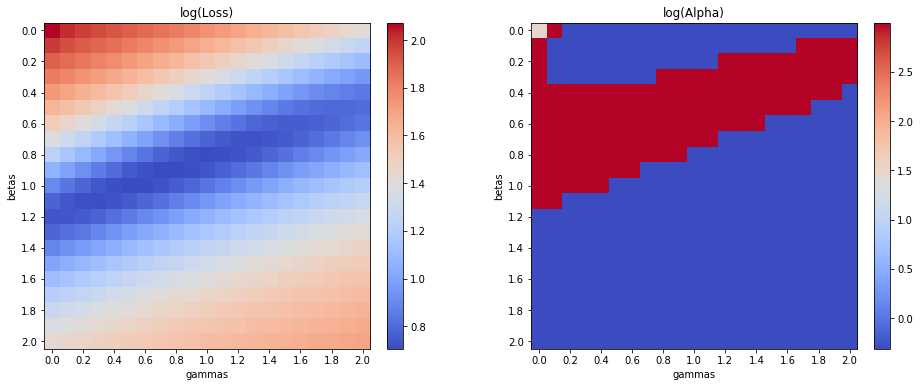

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

i = axs[0].imshow(np.log10(beta_gamma_loss), cmap="coolwarm")
axs[0].set_title("log(Loss)")
axs[0].set_xlabel("gammas")
axs[0].set_xticks(np.arange(0, grid_size, 2)) 
axs[0].set_xticklabels(np.linspace(0.0, 2.0, (grid_size + 1) // 2).round(1))
axs[0].set_ylabel("betas")
axs[0].set_yticks(np.arange(0, grid_size, 2)) 
axs[0].set_yticklabels(np.linspace(0.0, 2.0, (grid_size + 1) // 2).round(1))

fig.colorbar(i, ax=axs[0], fraction=0.046, pad=0.04)

i = axs[1].imshow(np.log10(beta_gamma_alphas), cmap="coolwarm")
axs[1].set_title("log(Alpha)")
axs[1].set_xlabel("gammas")
axs[1].set_xticks(np.arange(0, grid_size, 2)) 
axs[1].set_xticklabels(np.linspace(0.0, 2.0, (grid_size + 1) // 2).round(1))
axs[1].set_ylabel("betas")
axs[1].set_yticks(np.arange(0, grid_size, 2)) 
axs[1].set_yticklabels(np.linspace(0.0, 2.0, (grid_size + 1) // 2).round(1))
fig.colorbar(i, ax=axs[1], fraction=0.046, pad=0.04)

plt.show()

In [19]:
ind = np.unravel_index(beta_gamma_loss.argmin(), beta_gamma_loss.shape)
beta = betas[ind[0]]
gamma = gammas[ind[1]]
conf["travel_loss_kwargs"]["beta"] = beta
conf["travel_loss_kwargs"]["gamma"] = gamma
alpha, loss = find_alpha(0.0, 10.0, conf, k=3, max_depth=20)
print("Best beta: {:.03f}, Best gamma:  {:.03f}".format(beta, gamma))
print("Best alpha: {:.03f}".format(alpha))
print("Best loss: {:.03f}".format(loss))

Best beta: 0.900, Best gamma:  0.800
Best alpha: 0.000
Best loss: 5.077


В принципе ее результаты также выглядят лучше чем у однопараметрической модели с фиксированными степенями.

# Temp

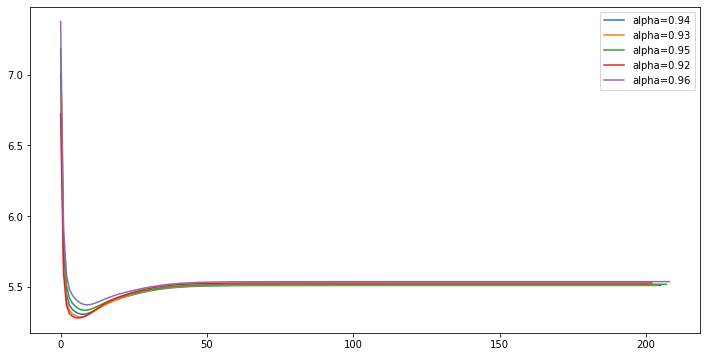

In [11]:
plt.figure(figsize=(12, 6))
best = np.argsort([losses[-1] for losses in losses_diff_alpha])[:5]
for i, alpha in enumerate(alphas[best]):
    plt.plot(losses_diff_alpha[best[i]], label="alpha={:0.2f}".format(alpha))
plt.legend()

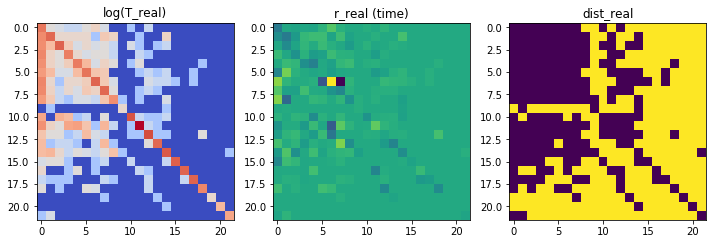

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.log(T_real + 1e-1), cmap="coolwarm")
axs[0].set_title("log(T_real)")

axs[1].imshow(T_real - T_pred)
axs[1].set_title("r_real (time)")

axs[2].imshow(dist_real)
axs[2].set_title("dist_real")

plt.show()

In [17]:
MSE()(T_real.sum(axis=0), T_pred.sum(axis=0))

4.226822582700519e-16

In [18]:
MSE()(T_real.sum(axis=1), T_pred.sum(axis=1))

4.644403206147772e-16